Vessl - Using Python SDK on Jupyter Notebook
------

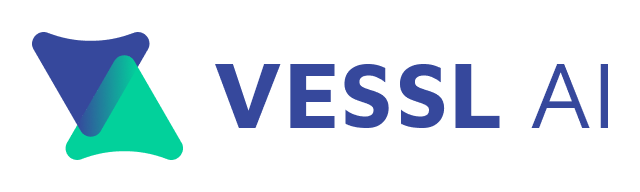

[Vessl](https://vessl.ai)은 머신러닝 연구자들이 팀과 함께 모델 학습과 모니터링을 더 효과적으로 할 수 있는 머신러닝 플랫폼입니다. 이 노트북에서는 유저의 로컬 환경에서 수행한 실험을 어떻게 Vessl과 연동하여 더 쉽고 효율적으로 연구를 할 수 있는지 설명드릴 예정입니다. Vessl에 대한 더 자세한 설명이 궁금하시면, [공식 문서](https://docs.vessl.ai/)를 참고해주세요!

[Vessl](https://vessl.ai) is a machine learning platform that allows researchers to train and monitor models in scale as a team. In this notebook, you'll see how you can integrate local ML experiments with Vessl to empower your research workflow. For more detailed information, check out our [docs](https://docs.vessl.ai/)!

### 1. Install Vessl SDK and required libraries

먼저 Vessl SDK와 간단한 실험에 필요한 라이브러리들을 설치해보겠습니다. 지금 Vessl의 workspace 환경에서 이 노트북을 실행하고 계시다면 Vessl SDK를 포함해서 대부분의 라이브러리들이 설치되어 있을 것입니다. 이 노트북에서의 예제는 Vessl SDK 0.1.15 버전 이상에서 작동합니다.

Let's install the Vessl SDK and required libraries first. If you're running this Jupyter Notebook on a Vessl workspace, most of these should already be installed. Examples in this Notebook run well on Vessl SDK versions 0.1.15 or higher.

In [ ]:
# This cell should return: ['vessl, version 0.1.15']

!!pip install matplotlib hypothesis torch watermark
!!pip install --upgrade vessl
!!vessl --version

In [ ]:
# Use the CLI to sign in into Vessl and configure a default organization and project
!!vessl configure

# You can also programatically set a default organization and project using the Python API
import vessl
vessl.configure(organization_name="vessl", project_name="examples")

In [ ]:
# Check other dependencies
import os
import matplotlib
import hypothesis
import torch
from torch import optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR
import watermark

import vessl 

%pylab
%matplotlib inline
%load_ext watermark
%watermark -v -p numpy,torch,torchvision

### 2. Prepare model code and dataset

이 예제에서는 간단한 2D CNN 기반 인공 신경망을 [MNIST](https://paperswithcode.com/dataset/mnist) 데이터셋으로 학습하여 0에서 9까지의 숫자를 구분하는 머신러닝 모델을 만들어보겠습니다. 예제에서는 공개되어 있는 torchvision의 데이터셋을 사용하였으나, Vessl의 [Dataset](https://docs.vessl.ai/user-guide/dataset) 기능을 이용하여 필요한 어떤 데이터셋이든 Vessl에서 불러와 사용하실 수 있습니다!

In this example, we will train an image classification model classifying numeric digits (0-9) using a simple 2D CNN and the [MNIST](https://paperswithcode.com/dataset/mnist) dataset. We used a publicly available dataset from torchvision for this example, but you can also import you own datasets using the [Dataset](https://docs.vessl.ai/user-guide/dataset) feature in Vessl!

In [ ]:
# Download MNIST training data

from torchvision import datasets
from torchvision.transforms import ToTensor
train_data = datasets.MNIST(
    root = 'data',
    train = True,                         
    transform = ToTensor(), 
    download = True,            
)
test_data = datasets.MNIST(
    root = 'data', 
    train = False, 
    transform = ToTensor()
)

print(f'The shape of train data: {train_data.data.shape}')
print(f'The shape of test data: {test_data.data.shape}')

In [ ]:
# Render some sample images from training data

figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5

for i in range(1, cols*rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")

plt.show()

In [ ]:
# Define data loader

from torch.utils.data import DataLoader

train_loader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True, num_workers=1)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=128, shuffle=False, num_workers=1)

In [ ]:
# Define model

import torch.nn as nn

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2)
        self.drop1 = nn.Dropout2d(0.25)
        self.drop2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)
        self.softmax = nn.LogSoftmax(1)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = self.drop1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.drop2(x)
        x = self.fc2(x)
        return self.softmax(x)
    
# Initialize model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNN().to(device)
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)

print(model)

### 3. Use vessl.log() to record model training and test steps

모델이 준비되었다면 트레이닝을 위한 스크립트를 작성할 차례입니다. Vessl에서는 vessl.log() 라는 간단한 인터페이스를 통해 실험의 메트릭과 로그, 추론 결과물 등 실험의 다양한 출력들을 기록할 수 있습니다. 기록한 결과물들은 Vessl의 실험 대시보드를 통해 언제든 확인하고, 다른 실험과 결과물들을 비교하고, 더 나은 결과를 낸 실험을 모델로 저장해둘 수 있습니다. 여러분의 학습 코드에서 기록이 필요한 곳에 vessl.log()를 넣어두기만 하면 됩니다!
* vessl.log() 에 대한 자세한 내용은 [공식 문서의 SDK 항목](https://docs.vessl.ai/api-reference/python-sdk/vessl.log)을 참고해주세요.
* 실험 결과 기록과 조회에 대한 자세한 내용은 [공식 문서의 Experiment 항목](https://docs.vessl.ai/user-guide/experiment)을 참고해주세요.

When the model code is ready, the next step is to write a script for training and testing the model. With Vessl, you can record outputs from your training such as metrics, logs, and inferences. You can always view the results, compare with other experiments, and save the best one as a model on our Experiment Tracking page. The only thing you need to do is add vessl.log() in your training code!
* For more information about vessl.log(), check out our [Python SDK docs](https://docs.vessl.ai/api-reference/python-sdk/vessl.log).
* For more information on experiment tracking, check out our [experiment docs](https://docs.vessl.ai/user-guide/experiment).

In [ ]:
# Train function (with vessl logging)

from torch.autograd import Variable

def train(model, device, train_loader, optimizer, epoch, start_epoch):
    model.train()
    loss = 0
    for batch_idx, (data, label) in enumerate(train_loader):
        data, label = data.to(device), label.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, label)
        loss.backward()
        optimizer.step()
        if batch_idx % 128 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch + 1, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

    # Logging loss metrics to Vessl
    vessl.log(
        step=epoch + start_epoch + 1,
        payload={'loss': loss.item()}
    )

In [ ]:
# Test function (with vessl plot uploading)

def test(model, device, test_loader, save_image):
    model.eval()
    test_loss = 0
    correct = 0
    test_images = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            test_images.append(vessl.Image(
                data[0], caption="Pred: {} Truth: {}".format(pred[0].item(), target[0])))

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset), test_accuracy))

    # Saving inference results with caption into Vessl
    if save_image:
        vessl.log({"Examples": test_images})

    return test_accuracy

### 4. Train the model

모든 준비가 완료되었으면 실험을 수행해봅시다! vessl.init() 을 이용해서 새로운 실험을 생성 후 실험 스크립트를 실행하면 자동으로 생성된 실험에 실험 기록들이 저장됩니다. 노트북 환경에서는 실험이 완료된 후 vessl.finish()로 실험을 종료할 수 있습니다. 노트북이 아닌 실제 실험 환경에서는 스크립트를 실행하는 프로세스가 종료될 시 자동으로 vessl.finish()가 호출되므로 직접 호출을 하실 필요가 없습니다.

Let's execute the actual experiment! You can create a new experiment by calling vessl.init() and our SDK will record all metrics and logs onto the newly created experiment. After the experiment is finished, you can call vessl.finish() to mark experiment as completed. We automatically call vessl.finish() when your script exits so the last step is optional.

In [ ]:
# Initialize new experiment via Vessl SDK 

vessl.init()

In [ ]:
# Hyperparameters
epochs = 10
batch_size = 128
learning_rate = 0.01
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = StepLR(optimizer, step_size=1, gamma=0.7)

# Train the model
for epoch in range(epochs):
    train(model, device, train_loader, optimizer, epoch, 0)
    test(model, device, test_loader, True)

    scheduler.step()

In [ ]:
# Finish experiment
vessl.finish()

### 5. More Informations

Python SDK을 이용한 실험 기록/관리 기능 외에도, Vessl은 더 효율적인 머신러닝 연구를 위한 다양한 기능을 지원합니다! 아래와 같은 기능들이 있습니다.
- 로컬 환경 대신 Vessl 클러스터에서 실험을 실행하여, 여러개의 실험이 동시에 수행되는 동안 다른 중요한 일들에 집중하실 수 있습니다. [Creating an Experiment](https://docs.vessl.ai/user-guide/experiment/creating-an-experiment) 항목을 참고해주세요.
- 대규모의 컴퓨팅 자원이 필요할 경우 여러 노드에서 분산 학습을 진행하실 수 있습니다. [Distributed Experiment](https://docs.vessl.ai/user-guide/experiment/distributed-experiment) 항목을 참고해주세요.
- 최적의 결과를 내기 위한 하이퍼파라미터를 자동으로 탐색해주는 Hyperparamter Optimization 기능을 지원합니다. [Sweep](https://docs.vessl.ai/user-guide/sweep) 항목을 참고해주세요.

그 외에도 Vessl의 다양한 기능들을 이용하여 머신러닝 작업의 생산성을 극대화하실 수 있습니다! [커뮤니티 슬랙에 가입](https://join.slack.com/t/vessl-ai-community/shared_invite/zt-w7phk2pj-XwGK42BchBv5qeXYH42iNQ)하셔서 다른 머신러닝 연구자 및 엔지니어들과 교류하고, Vessl 팀과 질의응답을 하시거나 Best practice들을 서로 공유하실 수 있습니다. 감사합니다!


Vessl supports many other features that will improve your machine learning research workflow! For instance:
- You can also execute your training job on top of Vessl-managed clusters to run the experiments asynchronously and focus on other important things. See [Creating an Experiment](https://docs.vessl.ai/user-guide/experiment/creating-an-experiment) for more information.
- Vessl supports distributed experiments for training that needs large amounts of computing resources - See [Distributed Experiment](https://docs.vessl.ai/user-guide/experiment/distributed-experiment) for more information.
- Hyperparameter optimzation can also be done easily with Vessl! See [Sweep](https://docs.vessl.ai/user-guide/sweep) for more information.

Maximize your research productivity with Vessl - Join our [Slack community](https://join.slack.com/t/vessl-ai-community/shared_invite/zt-w7phk2pj-XwGK42BchBv5qeXYH42iNQ) to chat with other ML researchers, ask questions, provide feedback, or share best practices. Thank you very much!